In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [22]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [23]:
from torch.utils.data import TensorDataset, DataLoader,Dataset

In [24]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import LightningModule, LightningDataModule

In [25]:
import warnings 
warnings.filterwarnings('ignore')

In [26]:
import torchmetrics 
from torchmetrics.classification import BinaryAccuracy

In [27]:
from datetime import datetime

In [ ]:
#skip

In [ ]:
data = pd.read_pickle('jd_2_with_macro_v3.pkl')

In [ ]:
data_reset = data.reset_index()

In [ ]:
target = data_reset[['account','target_24m']]

In [ ]:
target_total = target.groupby('account').mean()

In [ ]:
features = data_reset[['account','day_payment', 'balance_sum', 'day_debt_bad_max',
                      'ipi1', 'ipi2', 'ppi1', 'ppi2',
       'ppi3', 'cpi1', 'unemp1', 'gdp_nom', 'gdp_yoy', 'salary', 'sales',
       'income_nom', 'income_real_1', 'income_real_2', 'USDRUB1', 'EURRUB1',
       'brent', 'USDRUB_pct', 'brent_pct', 'EURRUB_pct', 'invst', 'key_rate']]

In [ ]:
features.account.value_counts().mean()

In [ ]:
indexes = data.index.get_level_values(0)

In [ ]:
x = np.array(indexes)
unique, counts = np.unique(x, return_counts=True)

In [ ]:
counts_accs = np.asarray((unique, counts)).T

In [ ]:
filter_ = counts_accs[counts_accs[:,1] >= 24][:,0]

In [ ]:
filter_df  = data[data.index.get_level_values(0).isin(filter_)]

In [ ]:
filter_df.iloc[::2,3:5]

In [ ]:
filter_drop = filter_df.copy()
filter_drop_reset = filter_drop.reset_index()

In [ ]:
new_df = pd.DataFrame()

In [ ]:
filter_drop_reset.head()

In [ ]:
for idx in tqdm(filter_drop.index.get_level_values('account').unique()):
    index_to_drop = filter_drop_reset[filter_drop_reset['account'] == idx][-24:]
    
    #filter_drop.drop((idx, i.strftime('%Y-%m-%d')), axis=0, inplace=True)
    
    new_df = new_df.append(index_to_drop)

In [ ]:
new_df.to_pickle('mid_term.pkl')

In [ ]:
del data, data_reset, target, target_total, filter_df, filter_drop, filter_drop_reset,features

In [ ]:
# start

In [28]:
from sklearn.preprocessing import LabelEncoder

In [173]:
new_df = pd.read_pickle('mid_term.pkl')

In [174]:
#new_df_new = new_df[new_df['sent_date'] > '2021-12-01']

In [10]:
# feature imp

In [175]:
new_df_copy = new_df.copy()

In [176]:
new_df_copy = new_df_copy[pd.notnull(new_df_copy['balance_sum'])]

In [177]:
sort_idx_notna = new_df_copy.groupby('account').size().sort_values(ascending=False).loc[lambda x : x >=24].index

In [178]:
new_df_copy = new_df_copy[new_df_copy.account.isin(sort_idx_notna)]

In [179]:
target = new_df_copy[['account','target_24m']].drop_duplicates()

In [36]:
le = LabelEncoder()
mrf_id = le.fit_transform(new_df_copy['mrf_service_id'])
mrf_id = pd.get_dummies(mrf_id, prefix = 'mrf')

In [37]:
new_df_copy.reset_index(inplace=True)
new_df_copy.drop(columns = 'index', inplace = True)

In [38]:
new_df_copy = pd.concat([new_df_copy, mrf_id], axis = 1)

In [39]:
le = LabelEncoder()
rf_id = le.fit_transform(new_df_copy['rf_service_id'])
rf_id = pd.get_dummies(rf_id, prefix = 'rf')

In [40]:
new_df_copy = pd.concat([new_df_copy, rf_id], axis = 1)

In [41]:
#from tsfresh import extract_features, select_features
#from tsfresh.utilities.dataframe_functions import impute
#train = new_df_copy[['account', 'pay_date', 'day_payment']]
#X = extract_features(train, column_id="account", column_sort="pay_date", impute_function=impute)
#select = select_features(X, np.array(target['target_24m']))

In [42]:
FEATURES = ['day_payment', 'balance_sum', 'ipi1', 'ipi2',
       'ppi1', 'ppi2', 'ppi3', 'cpi1', 'unemp1', 'gdp_nom', 'gdp_yoy',
       'salary', 'sales', 'income_nom', 'income_real_1', 'income_real_2',
       'USDRUB1', 'EURRUB1', 'brent', 'USDRUB_pct', 'brent_pct', 'EURRUB_pct',
       'invst', 'key_rate', 'mrf_0', 'mrf_1', 'mrf_2', 'mrf_3', 'mrf_4',
       'mrf_5', 'mrf_6', 'rf_0', 'rf_1', 'rf_2', 'rf_3', 'rf_4', 'rf_5', 'rf_6', 'rf_7',
       'rf_8', 'rf_9', 'rf_10', 'rf_11', 'rf_12', 'rf_13', 'rf_14', 'rf_15',
       'rf_16', 'rf_17', 'rf_18', 'rf_19', 'rf_20', 'rf_21', 'rf_22', 'rf_23',
       'rf_24', 'rf_25', 'rf_26', 'rf_27', 'rf_28', 'rf_29', 'rf_30', 'rf_31',
       'rf_32', 'rf_33', 'rf_34', 'rf_35', 'rf_36', 'rf_37', 'rf_38', 'rf_39',
       'rf_40', 'rf_41', 'rf_42', 'rf_43', 'rf_44', 'rf_45', 'rf_46', 'rf_47',
       'rf_48', 'rf_49', 'rf_50', 'rf_51', 'rf_52', 'rf_53', 'rf_54', 'rf_55', 'rf_56',
       'rf_57', 'rf_58', 'rf_59', 'rf_60', 'rf_61', 'rf_62', 'rf_63', 'rf_64',
       'rf_65', 'rf_66', 'rf_67', 'rf_68', 'rf_69', 'rf_70', 'rf_71', 'rf_72',
       'rf_73', 'rf_74']

In [43]:
FEATURES_scale = ['day_payment', 'balance_sum', 'ipi1', 'ipi2',
       'ppi1', 'ppi2', 'ppi3', 'cpi1', 'unemp1', 'gdp_nom', 'gdp_yoy',
       'salary', 'sales', 'income_nom', 'income_real_1', 'income_real_2',
       'USDRUB1', 'EURRUB1', 'brent', 'USDRUB_pct', 'brent_pct', 'EURRUB_pct',
       'invst', 'key_rate']

In [44]:
X_train = new_df_copy[['account', 'day_payment', 'balance_sum', 'ipi1', 'ipi2',
       'ppi1', 'ppi2', 'ppi3', 'cpi1', 'unemp1', 'gdp_nom', 'gdp_yoy',
       'salary', 'sales', 'income_nom', 'income_real_1', 'income_real_2',
       'USDRUB1', 'EURRUB1', 'brent', 'USDRUB_pct', 'brent_pct', 'EURRUB_pct',
       'invst', 'key_rate', 'mrf_0', 'mrf_1', 'mrf_2', 'mrf_3', 'mrf_4',
       'mrf_5', 'mrf_6', 'rf_0', 'rf_1', 'rf_2', 'rf_3', 'rf_4', 'rf_5', 'rf_6', 'rf_7',
       'rf_8', 'rf_9', 'rf_10', 'rf_11', 'rf_12', 'rf_13', 'rf_14', 'rf_15',
       'rf_16', 'rf_17', 'rf_18', 'rf_19', 'rf_20', 'rf_21', 'rf_22', 'rf_23',
       'rf_24', 'rf_25', 'rf_26', 'rf_27', 'rf_28', 'rf_29', 'rf_30', 'rf_31',
       'rf_32', 'rf_33', 'rf_34', 'rf_35', 'rf_36', 'rf_37', 'rf_38', 'rf_39',
       'rf_40', 'rf_41', 'rf_42', 'rf_43', 'rf_44', 'rf_45', 'rf_46', 'rf_47',
       'rf_48', 'rf_49', 'rf_50', 'rf_51', 'rf_52', 'rf_53', 'rf_54', 'rf_55', 'rf_56',
       'rf_57', 'rf_58', 'rf_59', 'rf_60', 'rf_61', 'rf_62', 'rf_63', 'rf_64',
       'rf_65', 'rf_66', 'rf_67', 'rf_68', 'rf_69', 'rf_70', 'rf_71', 'rf_72',
       'rf_73', 'rf_74']]

In [45]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[FEATURES_scale] = scaler.fit_transform(X_train[FEATURES_scale])

In [46]:
sequences = []

for idx, group in tqdm(X_train.groupby('account')):
    
    seq_feat = group[FEATURES]
    label = target[target.account == idx].iloc[0].target_24m
    
    sequences.append((seq_feat, int(label)))

100%|███████████████████████████████████| 72862/72862 [00:37<00:00, 1956.53it/s]


In [36]:
from sklearn.model_selection import train_test_split
train_seq, test_seq = train_test_split(sequences, test_size = 0.2)

In [47]:
del new_df, new_df_copy, new_df_new, X_train

## Dataset

In [48]:
from dataset_lstm import Lstm_Dataset

In [49]:
class SurfaceModule(LightningDataModule):
    
    def __init__(self, train_seq, test_seq, batch_size):
        super().__init__()
        self.train_seq = train_seq
        self.test_seq = test_seq
        self.batch_size = batch_size
        
    def setup(self, stage = None):
        self.train_dataset = Lstm_Dataset(self.train_seq)
        self.test_dataset = Lstm_Dataset(self.test_seq)
    
    def train_dataloader(self):
        
        return( DataLoader(
        self.train_dataset, 
        batch_size = self.batch_size,
        shuffle = True, num_workers = 4))
    
    def val_dataloader(self):
        
        return( DataLoader(
        self.test_dataset, 
        batch_size = self.batch_size,
        shuffle = False, num_workers = 4))
    
    def test_dataloader(self):
        
        return( DataLoader(
        self.test_dataset, 
        batch_size = self.batch_size,
        shuffle = False, num_workers = 4))

In [50]:
EPOCHS = 100
BATCH_SIZE = 256


data_module = SurfaceModule(train_seq, test_seq, BATCH_SIZE)

NameError: name 'train_seq' is not defined

## Model

In [51]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

In [52]:
class _SepConv1d(nn.Module):
    
    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
        self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

In [53]:
class SepConv1d(nn.Module):

    def __init__(self, ni, no, kernel, stride, pad, 
                 drop=None, bn=True,
                 activ=lambda: nn.PReLU()):
    
        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if bn:
            layers.append(nn.BatchNorm1d(no))
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.layers(x)

In [54]:
class Flatten(nn.Module):

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

In [55]:
from torch.autograd import Variable

In [56]:
class LSTM_Model(nn.Module):
    
    def __init__(self, n_features, n_classes, dropout, n_hidden = 256, n_layers = 3, attention_cnn = True):
        super().__init__()
        
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.n_classes = n_classes
        self.attention_cnn = attention_cnn
        self.fft = nn.Sequential(
            SepConv1d(n_features, 32, 8, 2, 4, drop = dropout),
            SepConv1d(32,  32, 3, 1, 1, drop = dropout),
            SepConv1d(32,  64, 6, 2, 4, drop = dropout),
            SepConv1d(64,  64, 3, 1, 1, drop = dropout),
            SepConv1d(64, 128, 6, 4, 4, drop = dropout),
            SepConv1d(128, 128, 6, 4, 4, drop = dropout),
            SepConv1d(128, 256, 6, 2, 3),
            Flatten(),
            nn.Dropout(dropout), nn.Linear(512, 256), nn.PReLU(), nn.BatchNorm1d(256))
            #nn.Dropout(dropout), nn.Linear(256 , 128), nn.PReLU(), nn.BatchNorm1d(128))
        
        
        
        self.lstm = nn.LSTM(input_size = n_features, 
                           hidden_size = n_hidden,
                           num_layers = n_layers,
                           bidirectional = True,
                           #batch_first = True,
                           dropout = dropout)
        
        self.out = nn.Sequential(nn.Linear(768,256), nn.ReLU(inplace = True),
            nn.Linear(256, 64), nn.ReLU(inplace=True), nn.Linear(64, n_classes))
        
        self.init_weights(nn.init.kaiming_normal_)
        
    def attention_net(self, lstm_output, final_state):
        
        hidden = final_state.view(-1, self.n_hidden * 2, self.n_layers)  
        attn_weights = torch.bmm(lstm_output, hidden)
        soft_attn_weights = F.softmax(attn_weights, 1)
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights)
        return context, soft_attn_weights.data.numpy()
        
    def init_weights(self, init_fn):
        def init(m): 
            for child in m.children():
                if isinstance(child, nn.Conv1d):
                    init_fn(child.weights)
        init(self)
        
    def forward(self, x):
        
        if self.attention_cnn:
        
            x_perm = x.permute(1,0,2)
            hidden_state = Variable(torch.zeros(self.n_layers * 2 , x_perm.shape[1] , self.n_hidden)) 
            cell_state = Variable(torch.zeros(self.n_layers * 2 , x_perm.shape[1], self.n_hidden)) 

            output, (final_hidden_state, final_cell_state) = self.lstm(x_perm, (hidden_state, cell_state))
            output = output.permute(1, 0, 2)
            attn_output, attention = self.attention_net(output, final_hidden_state)
            
            self.fft_out = self.fft(x.permute(0,2,1))
        
            t_in = torch.cat([attn_output.sum(2), self.fft_out], dim=1)
            out = self.out(t_in)
        
        else:
        
            self.lstm.flatten_parameters()
            _, (self.hidden, _) = self.lstm(x)
            
            model_test = nn.Sequential(nn.Linear(256,64), nn.ReLU(), nn.Linear(64, self.n_classes))
            out = model_test(self.hidden[-1])
        
        
            
        return out
    

In [57]:
class LSTM_PL(LightningModule):
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.save_hyperparameters()
        
        self.train_acc = BinaryAccuracy()
        self.val_acc = BinaryAccuracy()
        
        self.model = LSTM_Model(n_features, n_classes, dropout = 0.5)
        self.criterion = nn.BCEWithLogitsLoss()
        #self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        
        output = self.model(x['sequence'])
        output = output.view(-1)

        return output

    def training_step(self, batch, *args):
        
        sequences = batch['sequence']
        labels = batch['label'].float()
        
        output = self.forward(batch)
        loss = self.criterion(output, labels.to(device))
    
        self.train_acc(output.round(), labels)
        
        self.log("training_loss", loss.item(), prog_bar = True, logger = True, on_step = True, on_epoch=True)
        self.log("training_accuracy", self.train_acc, prog_bar = True, logger = True, on_step = True, on_epoch=True)
        return {"loss": loss}
    

    def validation_step(self, batch, *args):
        
        sequences = batch['sequence']
        labels = batch['label'].float()
        
        output = self.forward(batch)
        loss = self.criterion(output, labels.to(device))
        
        self.val_acc(output.round(), labels)
        self.log("val_loss", loss.item(), prog_bar = True, logger = True, on_step = False, on_epoch=True)
        self.log("val_accuracy", self.val_acc, prog_bar = True, logger = True, on_step = False, on_epoch=True)
        return {"loss": loss}

    def test_step(self, batch, *args):
        
        sequences = batch['sequence']
        labels = batch['label']
        
        output = self.forward(batch)
        loss = self.criterion(output, batch['label'].to(device))
        predictions = torch.argmax(output, dim = 1)
        
        self.log("test_loss", loss.item(), prog_bar = True, logger = True, on_step = False, on_epoch=True)
        return {"loss": loss, "accuracy" : step_acc}
    
    def configure_optimizers(self):
        
        
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size = 20, gamma = 0.5)
        return {"optimizer": optimizer, 
               "lr_scheduler": {
                   "scheduler": scheduler,
                   "monitor": "training_loss"
               }}

In [58]:
model = LSTM_PL(
n_features = len(FEATURES),
n_classes = 1).to(device)

In [59]:
from pytorch_lightning.callbacks import ModelCheckpoint

In [83]:
checkpoint_callbacks = ModelCheckpoint(dirpath = 'lstm_models', save_top_k = 3,
                                       filename = "high-bce-{epoch}-{val_accuracy:.2f}",
                                      monitor = 'val_accuracy', mode = 'max')
trainer = Trainer(max_epochs = EPOCHS, callbacks = [checkpoint_callbacks], gradient_clip_val=0.01)
trainer.fit(model, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params
------------------------------------------------
0 | train_acc | BinaryAccuracy    | 0     
1 | val_acc   | BinaryAccuracy    | 0     
2 | model     | LSTM_Model        | 4.3 M 
3 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.274    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [84]:
torch.save(model.state_dict(), './lstm_models/model_train_last_full.pt')

In [60]:
model = LSTM_PL(n_features = len(FEATURES),n_classes = 1).to(device)
model.load_state_dict(torch.load('./lstm_models/model_train_last_full.pt'))
model.eval()

LSTM_PL(
  (train_acc): BinaryAccuracy()
  (val_acc): BinaryAccuracy()
  (model): LSTM_Model(
    (fft): Sequential(
      (0): SepConv1d(
        (layers): Sequential(
          (0): _SepConv1d(
            (depthwise): Conv1d(106, 106, kernel_size=(8,), stride=(2,), padding=(4,), groups=106)
            (pointwise): Conv1d(106, 32, kernel_size=(1,), stride=(1,))
          )
          (1): PReLU(num_parameters=1)
          (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Dropout(p=0.5, inplace=False)
        )
      )
      (1): SepConv1d(
        (layers): Sequential(
          (0): _SepConv1d(
            (depthwise): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), groups=32)
            (pointwise): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
          )
          (1): PReLU(num_parameters=1)
          (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Dropout(p=0.5, in

In [ ]:
# test

In [85]:
new_df = pd.read_pickle('mid_term.pkl')

In [ ]:
# прогнать верхнюю часть в загрузке на тест

In [61]:
test_data = DataLoader(Lstm_Dataset(sequences), batch_size = 128, shuffle = False, num_workers = 2)

In [62]:
from sklearn.metrics import confusion_matrix
output_total = []
for batch in tqdm(test_data):
    output = model(batch)
    output = output.detach().numpy()
    output_total.append(output)

100%|█████████████████████████████████████████| 570/570 [05:27<00:00,  1.74it/s]


In [68]:
total = np.concatenate(output_total, axis=0)

In [71]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [73]:
vfunc = np.vectorize(sigmoid)
prob_total = vfunc(total)

In [1]:
def get_model_profit(y_test, y_pred, debt: list, fee = 2000):
    
    df = pd.DataFrame(zip(y_test, y_pred, debt), columns = ['target', 'predict', 'debt'])
    
    TP = df.query('target == 1 and predict == 1')
    TP_eff = TP['debt'].sum() + len(TP)*fee
    
    TN = df.query('target == 0 and predict == 0')
    TN_eff = 0 #len(TN)*fee
    
    FN = df.query('target == 1 and predict == 0')
    FN_eff = FN['debt'].sum()
    
    FP = df.query('target == 0 and predict == 1')
    FP_eff = len(FP)*fee
    
    profit = TP_eff + TN_eff - FN_eff - FP_eff
    
    return round(profit,2)

In [184]:
y = target['target_24m'].values

In [185]:
dolg = new_df_copy[['account','dolg_loaded']].drop_duplicates()['dolg_loaded'].values

In [202]:
short_frame = new_df_copy[['account', 'sent_date', 'dolg_sent', 'target_24m']].drop_duplicates()

In [203]:
short_frame['probs'] = prob_total

In [227]:
short_qvartal = short_frame[(short_frame['sent_date'] > '2022-04-01')&(short_frame['sent_date'] < '2022-07-01')]

In [228]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score, precision_score
payments = []
for i in tqdm(np.linspace(0,1,41)):
    round_prob = np.where(short_qvartal['probs'].values > i, 1, 0)
    payments.append([[i*100, get_model_profit(short_qvartal['target_24m'].values, round_prob, short_qvartal['dolg_sent'].values), precision_score(short_qvartal['target_24m'].values, round_prob) ]])

100%|███████████████████████████████████████████| 41/41 [00:04<00:00,  8.75it/s]


In [235]:
print(classification_report(short_qvartal['target_24m'].values, np.where(short_qvartal['probs'].values > 0.8, 1, 0)))

              precision    recall  f1-score   support

           0       0.64      0.97      0.77     10047
           1       0.34      0.03      0.05      5616

    accuracy                           0.63     15663
   macro avg       0.49      0.50      0.41     15663
weighted avg       0.53      0.63      0.51     15663



In [231]:
print(confusion_matrix(short_qvartal['target_24m'].values, np.where(short_qvartal['probs'].values > 0.15, 1, 0)))

[[3154 6893]
 [1749 3867]]


In [232]:
payments

[[[0.0, 13769808.0, 0.3585520015322735]],
 [[2.5, 9868785.25, 0.35762453774200564]],
 [[5.0, 8418546.5, 0.3579076170082594]],
 [[7.500000000000001, 7552663.5, 0.3581864379863427]],
 [[10.0, 6560378.75, 0.3576093246259403]],
 [[12.5, 5381663.0, 0.35757206304972566]],
 [[15.000000000000002, 4177255.0, 0.35938661710037173]],
 [[17.5, 2869990.5, 0.3601872137024497]],
 [[20.0, 1698274.0, 0.3616365568544102]],
 [[22.5, 651553.0, 0.363543557168784]],
 [[25.0, -379958.0, 0.3659099186597062]],
 [[27.500000000000004, -1543003.0, 0.36594012605042014]],
 [[30.000000000000004, -2986374.5, 0.3667931135103589]],
 [[32.5, -4786648.0, 0.3674402846010503]],
 [[35.0, -6347756.0, 0.37109297232729443]],
 [[37.5, -7907019.5, 0.37279774489076817]],
 [[40.0, -8979514.0, 0.37516979081771257]],
 [[42.50000000000001, -10143604.75, 0.37258013329101874]],
 [[45.0, -11047990.0, 0.3683254631311297]],
 [[47.5, -11767012.5, 0.36236647493837304]],
 [[50.0, -12393228.0, 0.3614180478821363]],
 [[52.5, -13301894.5, 0.3601

In [142]:
import matplotlib.pyplot as plt

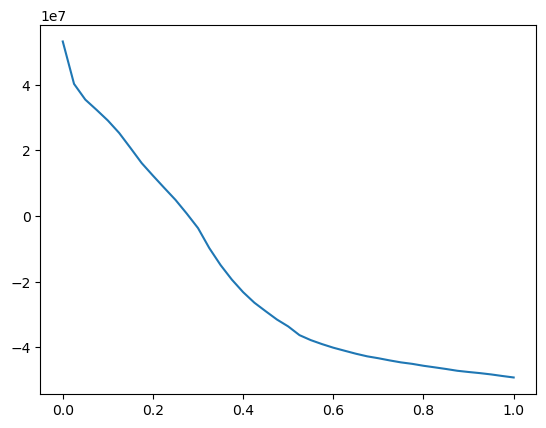

In [143]:
plt.plot(np.linspace(0,1,41), payments)

In [ ]:
def calculate_output_length(length_in, kernel_size, stride, padding, dilation=1):
    return (length_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

In [ ]:
calculate_output_length(2, 6, 2, 3)

In [69]:
torch.rand(256,24,106).permute(0,2,1).shape

torch.Size([256, 106, 24])